## Example with CNN-LSTM on live BTC close price using the full data

In [120]:
import os
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/Colab Notebooks/sats4u/')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [121]:
! pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [122]:
import json
import sys
import pandas as pd
import numpy as np
import math
from datetime import datetime
import time
import matplotlib.pyplot as plt
import mplfinance as mpf
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
import tensorflow as tf
import src.loadcrypto as lc
import src.featbuild as fb
import src.candles2timeseries as c2t
import src.sats2model as s2m
import src.timeutils as tu
import src.sats2backtest as s2b

np.random.seed(420)
os.environ['PYTHONHASHSEED'] = '0'
tf.random.set_seed(420)

## Load Asset Details, Binance client data and Download 15m candles from Binance

In [123]:
data_folder = "data/"
asset_details = pd.read_csv(data_folder + 'asset_details.csv')
secret_data_folder = '/content/drive/MyDrive/Colab Notebooks/crypto_project/crypto_data/'
secrets_filename = secret_data_folder+'data.json'
crypto = lc.CryptoData(asset_details,data_folder)
crypto.load_binance_client(secrets_filename,data1_str = 'DATA1',data2_str = 'DATA2i',testnet=False)
crypto.trade_time_units(dt=60,kline_size="15m",starting_date = '1 Mar 2017')
tickers=crypto.asset_details["Ticker"]
tickers = list(tickers[tickers=='BTCUSDT'].values)
ldata_df = crypto.load_cryptos(tickers,save = False)                             

All caught up..!
size of dataset: (170100, 8)


In [124]:
secrets_filename_test = secret_data_folder+'data_test.json'
crypto_test = lc.CryptoData(asset_details,data_folder)
crypto_test.load_binance_client(secrets_filename_test,data1_str = 'DATA1',data2_str = 'DATA2i',testnet=True)
crypto_test.trade_time_units(dt=60,kline_size="15m",starting_date = '1 Mar 2017')
tickers=crypto_test.asset_details["Ticker"]
tickers = list(tickers[tickers=='BTCUSDT'].values)
ldata_df_test = crypto_test.load_cryptos(tickers,save = False)  

All caught up..!
size of dataset: (167237, 8)


In [125]:
crypto.binance_client.get_account()

{'accountType': 'SPOT',
 'balances': [{'asset': 'BTC', 'free': '0.00224170', 'locked': '0.00000000'},
  {'asset': 'LTC', 'free': '0.00000000', 'locked': '0.00000000'},
  {'asset': 'ETH', 'free': '0.00000000', 'locked': '0.00000000'},
  {'asset': 'NEO', 'free': '0.00000000', 'locked': '0.00000000'},
  {'asset': 'BNB', 'free': '0.00000664', 'locked': '0.00000000'},
  {'asset': 'QTUM', 'free': '0.00000000', 'locked': '0.00000000'},
  {'asset': 'EOS', 'free': '0.00000000', 'locked': '0.00000000'},
  {'asset': 'SNT', 'free': '0.00000000', 'locked': '0.00000000'},
  {'asset': 'BNT', 'free': '0.00000000', 'locked': '0.00000000'},
  {'asset': 'GAS', 'free': '0.00000000', 'locked': '0.00000000'},
  {'asset': 'BCC', 'free': '0.00000000', 'locked': '0.00000000'},
  {'asset': 'USDT', 'free': '107.65342381', 'locked': '0.00000000'},
  {'asset': 'HSR', 'free': '0.00000000', 'locked': '0.00000000'},
  {'asset': 'OAX', 'free': '0.00000000', 'locked': '0.00000000'},
  {'asset': 'DNT', 'free': '0.000000

### Generate Candles and build features from technical analysis

In [126]:
can_btc = fb.Candles(ldata_df,"Bitcoin")
can_btc.buildfeatures()
ts_btc = c2t.Candle2TimeSeries(can_btc.candles, laststeps = 5000, step_back = 48, candle_step_str = "15m",
                lownorm = 0.2, upnorm= 0.8)

ts_btc.candles2ts()
ts_btc.x_candles = np.asarray(ts_btc.x_candles, dtype=np.float32)
ts_btc.x_time = np.asarray(ts_btc.x_time, dtype=np.float32)

Candles Normalized
Extracted last 5000 steps
Generated time-series
Normalized 'candles_norm' with shape : (5000, 9)
Feature data 'x_candles' with size : 4952
Feature data with time intervals 'x_time' with size : 4952


In [127]:
USE_PRETRAINED = True
PRESAVED_MODELDATE = "220625_20_46"
initial_timestamp = pd.Timestamp(datetime.strptime(PRESAVED_MODELDATE, '%y%m%d_%H_%M'))

if USE_PRETRAINED:
  model_name = f"model/LSTM_CNN_pretrained_{PRESAVED_MODELDATE}"
else:
  model_name = f"model/LSTM_CNN_model"

loaded_model =  s2m.TimeSeries2Model(ts_btc.x_candles, ts_btc.x_time, ts_btc.y, ts_btc.scaler ,split_fraction = 1)
loaded_model.sats2model()
loaded_model.load_model(model_name)
loaded_model.sats2pred(predict_on_test = False)
loaded_model.load_scaler(model_name + '/scaler.sav')
preds = c2t.denorm(loaded_model.scaler,can_btc.candles,loaded_model.preds)

In [128]:
new_time_steps = int((can_btc.candles.index[-1] - initial_timestamp)/(can_btc.candles.index[1] - can_btc.candles.index[0]))
new_time_steps

381

,Close,Pred Close
Date,,
2022-05-09 06:31:00,33461.46,33798.269344
2022-05-09 06:46:00,33571.73,33807.859919
2022-05-09 07:01:00,33695.50,33785.300792
2022-05-09 07:16:00,33542.97,33802.112121
2022-05-09 07:31:00,33573.00,33775.284697
...,...,...
2022-06-29 19:01:00,20093.99,20253.601812
2022-06-29 19:16:00,20142.35,20267.100629
2022-06-29 19:31:00,20128.28,20276.802493


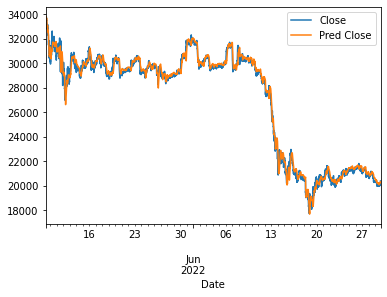

In [129]:
df_preds_true = tu.merge_true_preds(can_btc.candles,preds,period =  +1)
df_preds_true.dropna().plot()
df_preds_true.dropna()

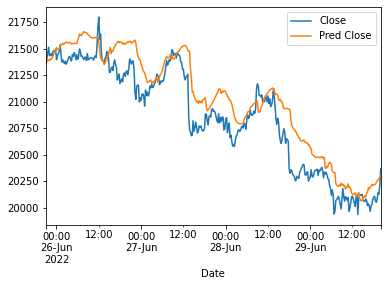

In [130]:
df_preds_true.dropna().iloc[-new_time_steps:].plot()

In [131]:
df_preds_true.dropna().iloc[-new_time_steps+300:]

,Close,Pred Close
Date,,
2022-06-29 00:01:00,20286.05,20569.187373
2022-06-29 00:16:00,20360.11,20553.547862
2022-06-29 00:31:00,20300.68,20503.732518
2022-06-29 00:46:00,20289.83,20497.703221
2022-06-29 01:01:00,20312.82,20494.495452
...,...,...
2022-06-29 19:01:00,20093.99,20253.601812
2022-06-29 19:16:00,20142.35,20267.100629
2022-06-29 19:31:00,20128.28,20276.802493


Initial time 2022-06-21 21:46:00
Final time 2022-06-29 20:01:00
Fee: 0.025
----------------------
Buy      751 ( 438 ok 313 ko )
Avg PCT gain: 1.0026167208056032
Avg PCT loss: 0.9977766511728139
Wins  PCT   0.5832223701731025
Avg PCT Gain.    1.0026167208056032
No-op    0
Wallet   8298.01200000001
Drawback -391.54999999999995
Kelly Fraction    0.1684567083374532
Total earned 8298.01200000001


/content/drive/MyDrive/Colab Notebooks/sats4u/src/sats2backtest.py:212: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  axes[1].stem(wallet_hist_df.index,wallet_hist_df.iloc[:,1])


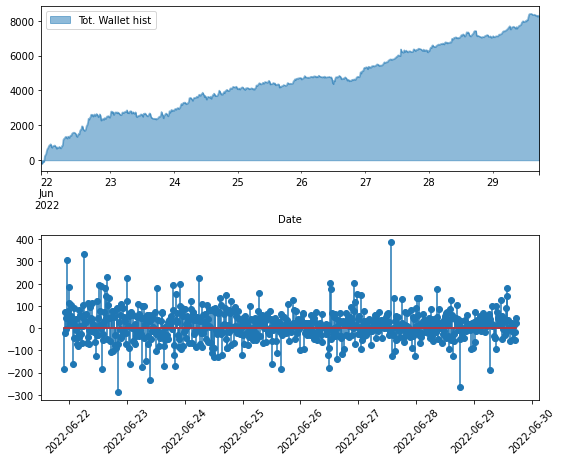

In [132]:
wallet_hist_df,wallet,kelly_frac = s2b.backtest_df(df_preds_true.dropna().iloc[-new_time_steps*2:], step_back = + 10 , 
                                                    long_short = "longshort", fee=0.025, cutoff_long = 10. ,cutoff_short = 10.0)
s2b.show_backtest_results(wallet,wallet_hist_df)

In [133]:
def tryexceptwait(func):
  def inner(*args,**kwargs):
        try:
          return func(*args, **kwargs)
        except:
          time.sleep(61)
          return func(*args,**kwargs)
  return inner

@tryexceptwait
def getminutedata(binance_client, ticker,interval, look_back):

    frame = pd.DataFrame(binance_client.get_historical_klines(ticker,interval, look_back + "min ago UTC"))

    frame = frame.iloc[:,:6]
    frame.columns = ['Time', 'Open', 'High', 'Low', 'Close', 'Volume']
    frame = frame.set_index("Time")
    frame.index = pd.to_datetime(frame.index,unit = "ms")
    frame = frame.astype(float)
    return frame

All caught up..!
size of dataset: (170098, 8)
Candles Normalized
Extracted last 2000 steps
Generated time-series
Normalized 'candles_norm' with shape : (2000, 9)
Feature data 'x_candles' with size : 1952
Feature data with time intervals 'x_time' with size : 1952
All caught up..!
size of dataset: (170099, 8)
Candles Normalized
Extracted last 2000 steps
Generated time-series
Normalized 'candles_norm' with shape : (2000, 9)
Feature data 'x_candles' with size : 1952
Feature data with time intervals 'x_time' with size : 1952
All caught up..!
size of dataset: (170099, 8)
Candles Normalized
Extracted last 2000 steps
Generated time-series
Normalized 'candles_norm' with shape : (2000, 9)
Feature data 'x_candles' with size : 1952
Feature data with time intervals 'x_time' with size : 1952
All caught up..!
size of dataset: (170099, 8)
Candles Normalized
Extracted last 2000 steps
Generated time-series
Normalized 'candles_norm' with shape : (2000, 9)
Feature data 'x_candles' with size : 1952
Feature

KeyboardInterrupt: ignored

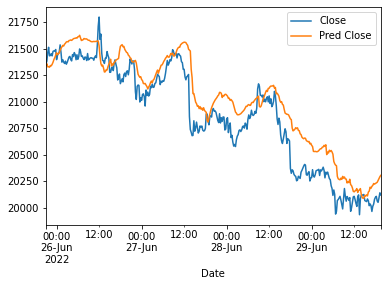

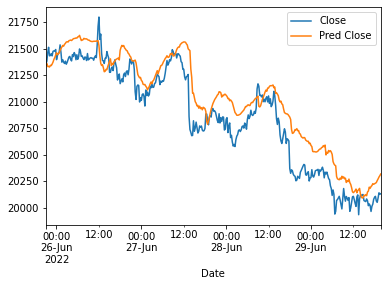

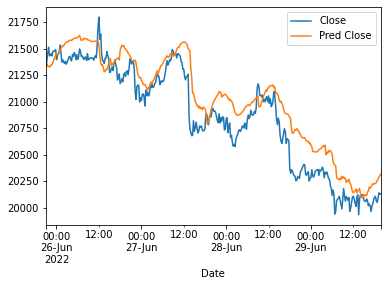

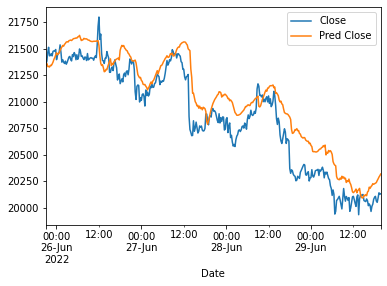

In [115]:
investment = 1000.
conservative_kelly = kelly_frac*.5
portfolio = investment
open_position = False
avg_change = 0.004
fee = 0.025

while True:

  ldata_df_new = crypto.load_cryptos(tickers,save = False)
  can_btc = fb.Candles(ldata_df_new,"Bitcoin")
  can_btc.buildfeatures()
  ts_btc = c2t.Candle2TimeSeries(can_btc.candles, laststeps = 2000, step_back = 48, candle_step_str = "15m",
                  lownorm = 0.2, upnorm= 0.8)

  ts_btc.candles2ts()
  ts_btc.x_candles = np.asarray(ts_btc.x_candles, dtype=np.float32)
  ts_btc.x_time = np.asarray(ts_btc.x_time, dtype=np.float32)
  initial_timestamp = pd.Timestamp(datetime.strptime(PRESAVED_MODELDATE, '%y%m%d_%H_%M'))
  loaded_model =  s2m.TimeSeries2Model(ts_btc.x_candles, ts_btc.x_time, ts_btc.y, ts_btc.scaler ,split_fraction = 1)
  loaded_model.sats2model()
  loaded_model.load_model(model_name)
  loaded_model.sats2pred(predict_on_test = False)
  loaded_model.load_scaler(model_name + '/scaler.sav')
  preds = c2t.denorm(loaded_model.scaler,can_btc.candles,loaded_model.preds)
  new_time_steps = int((can_btc.candles.index[-1] - initial_timestamp)/(can_btc.candles.index[1] - can_btc.candles.index[0]))
  df_preds_true = tu.merge_true_preds(can_btc.candles,preds,period = +1)
  df_preds_true.dropna().iloc[-new_time_steps:].plot()
  delta = df_preds_true.index[1]-df_preds_true.index[0]
  df_preds_true_shifted = df_preds_true.copy()
  df_preds_true_shifted.iloc[:,0] = df_preds_true.iloc[:,0].shift(10,delta)

  prev_true_close = df_preds_true_shifted.iloc[-2,0]
  prev_pred_close = df_preds_true_shifted.iloc[-2,1]
  pred_close = df_preds_true_shifted.iloc[-1,1]

  elapsed_minutes = (pd.Timestamp(datetime.now()) - df_preds_true.index[-1]).seconds/crypto.dt
  time_condition = delta.seconds/crypto.dt -1. < elapsed_minutes <  delta.seconds/crypto.dt + 1.

  if time_condition and open_position == False :

    if prev_true_close*(1+fee/10.) < pred_close:

        #get price
        dff = getminutedata(crypto.binance_client, tickers[0],'1m','120')
        # Calculate how much to buy
        buy_quantity = round(portfolio*conservative_kelly / float(dff['Close'].iloc[-1]))
        buy_quantity = 0.001
        order = crypto_test.binance_client.create_order(symbol=tickers[0],
                                                    side='BUY',
                                                    type='MARKET',
                                                    quantity= buy_quantity)
        order_time = pd.Timestamp(datetime.now())
        est_close_time = df_preds_true.index[-1]+delta
        open_position = True
        buyprice = float(order['fills'][0]['price'])
        
        while open_position :

          dff = getminutedata(crypto.binance_client, tickers[0],'1m','2')
          current_time = pd.Timestamp(datetime.now())
          time_until_close = est_close_time - current_time

          print('-----------------------------------')
          print(f'order filled at {str(order_time)}')
          print(f'current Close is {dff.Close[-1]}')
          print(f'current Target is {buyprice*(1+avg_change)} or close position in {str(time_until_close)}')
          print(f'current Stop is {buyprice*(1-avg_change)} or close position in {str(time_until_close)}')
        

In [ ]:
  delta = df_preds_true.index[1]-df_preds_true.index[0]
  df_preds_true_shifted = df_preds_true.copy()
  df_preds_true_shifted.iloc[:,0] = df_preds_true.iloc[:,0].shift(ts_btc.step_back,delta)
  df_preds_true_shifted

In [ ]:
df_preds_true